# Tree Health Prediction from NY 2015 Tree Census Data using Random Forest 

In [ ]:
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import preprocessing
%matplotlib inline

In [95]:
# Read in the census data 
df = pd.read_csv('2015-street-tree-census-tree-data.csv')
df = df.dropna(how='any')
df = df.drop(['spc_latin', 'status','stump_diam','created_at', 'address', 'state', 'block_id', 'x_sp', 'y_sp', 'council district', 'census tract', 'tree_id', 'bin', 'bbl'], axis=1)
df.columns
df = df.sample(frac=.1)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None): #
    #print(df.head())
df.head()



,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,...,borocode,borough,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,latitude,longitude
620963,17,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,"Stones,WiresRope,BranchLights",Yes,...,4,Queens,19,26,11,QN46,Bayside-Bayside Hills,4109300,40.773168,-73.779060
404927,17,OnCurb,Good,honeylocust,None,None,NoDamage,TreesCount Staff,Stones,Yes,...,4,Queens,32,31,10,QN55,South Ozone Park,4083800,40.672407,-73.821360
409768,38,OnCurb,Good,ginkgo,1or2,None,NoDamage,Volunteer,None,No,...,4,Queens,23,29,14,QN07,Hollis,4048400,40.715194,-73.756160
298695,4,OnCurb,Good,Kentucky coffeetree,None,None,NoDamage,NYC Parks Staff,None,No,...,5,Staten Island,50,64,24,SI25,Oakwood-Oakwood Beach,5013204,40.561082,-74.127282
655311,11,OnCurb,Good,Sophora,1or2,Unsure,NoDamage,Volunteer,BranchOther,No,...,3,Brooklyn,36,56,25,BK35,Stuyvesant Heights,3029100,40.688930,-73.933915


In [96]:
df.health.unique()

array(['Fair', 'Good', 'Poor'], dtype=object)

In [78]:
# Convert Categorical Values to Numeric 
le = preprocessing.LabelEncoder()
df2 = df.apply(le.fit_transform)

X = df2.drop(['health'], axis=1)
y = df2['health']
y_title = df['health']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [86]:
df2.head()

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,...,zip_city,community board,borocode,borough,cncldist,st_assem,st_senate,nta,nta_name,boro_ct
496684,2,1,1,59,3,2,1,1,22,0,...,2,52,3,3,18,3,1,148,9,1953
1713,4,1,1,81,3,2,1,1,63,1,...,5,16,1,0,13,54,19,71,166,414
408640,5,1,1,35,0,2,1,1,22,0,...,42,56,4,4,48,40,14,172,179,2097
489633,11,1,1,127,3,2,1,0,22,0,...,6,41,2,1,45,36,12,23,69,1150
242524,8,1,0,102,3,2,0,0,34,0,...,41,54,3,3,30,6,4,164,93,1811


In [97]:
#Random Forest Classification 
tree_model_rf = RandomForestClassifier(n_estimators=25)
tree_model_rf.fit(X_train, y_train)
y_model_tree_rf = tree_model_rf.predict(X_test)
accuracy_score(y_test, y_model_tree_rf)

0.8061430793157076

(-1, 28)

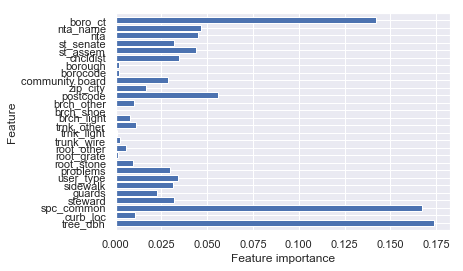

In [98]:
#Plot Feature Importance 
n_features = tree_model_rf.n_features_

plt.barh(np.arange(n_features), tree_model_rf.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)

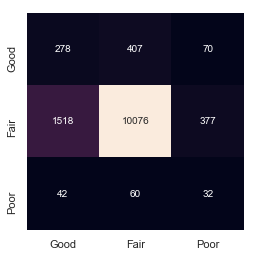

In [81]:
mat = confusion_matrix(y_test, y_model_tree_rf)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=y_title.unique(), yticklabels=y_title.unique())

In [99]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
feat_labels = X_train.columns

from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(tree_model_rf, threshold=0.1)

# Train the selector
sfm.fit(X_train, y_train)

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

tree_dbh
spc_common
boro_ct


In [100]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
rf_important = RandomForestClassifier(n_estimators=25, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
rf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [101]:
# Apply The Full Featured Classifier To The Test Data
y_pred = tree_model_rf.predict(X_test)

# View The Accuracy Of Our Full Feature (4 Features) Model
accuracy_score(y_test, y_pred)

0.8061430793157076

In [102]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = rf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (2 Features) Model
accuracy_score(y_test, y_important_pred)

0.758398133748056